In [1]:
#!/usr/bin/env python3.6
# -*- coding: utf-8 -*-

In [2]:
# Imports
import sys
import math
import numpy as np
from matplotlib import animation
from IPython.display import HTML
from matplotlib import pyplot as plt
plt.rcParams['animation.ffmpeg_path'] = '/usr/bin/ffmpeg'
import mpl_toolkits.mplot3d.axes3d as p3

In [3]:
np.random.seed(20)
np.set_printoptions(threshold=sys.maxsize)

In [4]:
%matplotlib inline

# Data

In [5]:
# Read data
path = '../../../dataset4_wbc/live_extraction/aliengo/step_0.065/continuous_1m.csv'
motion = np.genfromtxt(path, delimiter=',', dtype=np.float64)
contacts = np.genfromtxt(path, delimiter=',', usecols=(29, 30, 31, 32), dtype=bool)
print("Motion data has a length of ", len(motion))

Motion data has a length of  8334


In [6]:
motion.shape

(8334, 33)

## Height-Force plots

In [7]:
def get_specific_cmd(dataset, fwd, side, rot):
    if abs(fwd): 
        return np.where(dataset[:, 1] > 0)[0] if fwd > 0 else np.where(dataset[:, 1] < 0)[0]
    if abs(side): 
        return np.where(dataset[:, 2] > 0)[0] if side > 0 else np.where(dataset[:, 2] < 0)[0]
    if abs(rot): 
        return np.where(dataset[:, 3] > 0)[0] if rot > 0 else np.where(dataset[:, 3] < 0)[0]

In [8]:
def get_swinging_motions(dataset, height=1):
    # rf min height (i.e swining motion)
    fl_min_height = np.where(dataset[:, 6] < height)[0]
    fr_min_height = np.where(dataset[:, 9] < height)[0]
    rl_min_height = np.where(dataset[:, 12] < height)[0]
    rr_min_height = np.where(dataset[:, 15] < height)[0]
            
    return fl_min_height,fr_min_height,rl_min_height,rr_min_height

In [9]:
def quaternion_rotation_matrix(Q):
    """
    Covert a quaternion into a full three-dimensional rotation matrix.
 
    Input
    :param Q: A 4 element array representing the quaternion (q0,q1,q2,q3) 
 
    Output
    :return: A 3x3 element matrix representing the full 3D rotation matrix. 
             This rotation matrix converts a point in the local reference 
             frame to a point in the global reference frame.
    """
    # Extract the values from Q
    q0 = Q[3]
    q1 = Q[0]
    q2 = Q[1]
    q3 = Q[2]
     
    # First row of the rotation matrix
    r00 = 2 * (q0 * q0 + q1 * q1) - 1
    r01 = 2 * (q1 * q2 - q0 * q3)
    r02 = 2 * (q1 * q3 + q0 * q2)
     
    # Second row of the rotation matrix
    r10 = 2 * (q1 * q2 + q0 * q3)
    r11 = 2 * (q0 * q0 + q2 * q2) - 1
    r12 = 2 * (q2 * q3 - q0 * q1)
     
    # Third row of the rotation matrix
    r20 = 2 * (q1 * q3 - q0 * q2)
    r21 = 2 * (q2 * q3 + q0 * q1)
    r22 = 2 * (q0 * q0 + q3 * q3) - 1
     
    # 3x3 rotation matrix
    rot_matrix = np.array([[r00, r01, r02],
                           [r10, r11, r12],
                           [r20, r21, r22]])
                            
    return rot_matrix

### Step size

In [10]:
def get_step_size(dataset, footsteps, idx_coord, axes):
    # Footsteps sizes
    step_size_fr = []
    step_size_fl = []
    step_size_rr = []
    step_size_rl = []
    footstep_period = []
    
    # Compute step sizes
    idx = 1
    while idx < (len(footsteps)-1):
        time_diff = dataset[footsteps[idx], 0] - dataset[footsteps[idx-1], 0]
            
        if time_diff < 0.5 and np.any(dataset[footsteps[idx-1], 1:4]) and np.any(dataset[footsteps[idx], 1:4]):
            footstep_period.append(time_diff)
                        
            # Compute rotation matrices from odometry orientation
            R_prev = quaternion_rotation_matrix(dataset[footsteps[idx-1], 19:23])
            R_curr = quaternion_rotation_matrix(dataset[footsteps[idx], 19:23])
            
            # Odom base vectors
            prev_base = np.array([[dataset[footsteps[idx-1], 16], dataset[footsteps[idx-1], 17], 0]])
            curr_base = np.array([[dataset[footsteps[idx], 16], dataset[footsteps[idx], 17], 0]])
            
            # Rotate odometry estimation
            rotated_prev_base = R_prev.T @ prev_base.T
            rotated_curr_base = R_prev.T @ curr_base.T
            base_displacement = rotated_curr_base - rotated_prev_base
                                        
            if contacts[footsteps[idx], 0] and contacts[footsteps[idx], 3]:
                # FL vectors
                prev_fl = np.array([[dataset[footsteps[idx-1], 4], dataset[footsteps[idx-1], 5], 0]])
                curr_fl = np.array([[dataset[footsteps[idx], 4], dataset[footsteps[idx], 5], 0]])
                
                # RR vectors
                prev_rr = np.array([[dataset[footsteps[idx-1], 13], dataset[footsteps[idx-1], 14], 0]])
                curr_rr = np.array([[dataset[footsteps[idx], 13], dataset[footsteps[idx], 14], 0]])
                
                # Rotate FL vector
                rotated_prev_fl = R_prev.T @ prev_fl.T
                rotated_curr_fl = R_prev.T @ curr_fl.T
                fl_displacement = rotated_curr_fl - rotated_prev_fl
                
                # Rotate RR vector
                rotated_prev_rr = R_prev.T @ prev_rr.T
                rotated_curr_rr = R_prev.T @ curr_rr.T
                rr_displacement = rotated_curr_rr - rotated_prev_rr
                
                """
                print("Rotated prev fl: ", rotated_prev_fl.tolist())
                print("Rotated curr fl: ", rotated_curr_fl.tolist())
                print("Displacement fl: ", fl_displacement.tolist())
                print("Prev and curr fl pose: ", prev_fl, curr_fl)
                print("Prev and curr fl orientation: ", dataset[footsteps[idx-1], 19:23], dataset[footsteps[idx-1], 19:23])
                print("Prev and curr rotation matrix: ", R_prev, R_curr, "\n")
                """
                
                #step_size_fl.append(base_displacement[axes] + fl_displacement[axes])
                #step_size_rr.append(base_displacement[axes] + rr_displacement[axes])
                
                step_size_fl.append(fl_displacement[axes])
                step_size_rr.append(rr_displacement[axes])
            else:
                # FR vectors
                prev_fr = np.array([[dataset[footsteps[idx-1], 7], dataset[footsteps[idx-1], 8], 0]])
                curr_fr = np.array([[dataset[footsteps[idx], 7], dataset[footsteps[idx], 8], 0]])
                
                # RL vectors
                prev_rl = np.array([[dataset[footsteps[idx-1], 10], dataset[footsteps[idx-1], 11], 0]])
                curr_rl = np.array([[dataset[footsteps[idx], 10], dataset[footsteps[idx], 11], 0]])
                
                # Rotate FR vector
                rotated_prev_fr = R_prev.T @ prev_fr.T
                rotated_curr_fr = R_prev.T @ curr_fr.T
                fr_displacement = rotated_curr_fr - rotated_prev_fr
                
                # Rotate RL vector
                rotated_prev_rl = R_prev.T @ prev_rl.T
                rotated_curr_rl = R_prev.T @ curr_rl.T
                rl_displacement = rotated_curr_rl - rotated_prev_rl
                            
                #step_size_fr.append(base_displacement[axes] + fr_displacement[axes])
                #step_size_rl.append(base_displacement[axes] + rl_displacement[axes])
                
                step_size_fr.append(fr_displacement[axes])
                step_size_rl.append(rl_displacement[axes])
                
        idx += 1
                    
    # Convert to numpy array
    step_size_fl_numpy = np.array(step_size_fl)
    step_size_fr_numpy = np.array(step_size_fr)
    step_size_rl_numpy = np.array(step_size_rl)
    step_size_rr_numpy = np.array(step_size_rr)
    footstep_period_numpy = np.array(footstep_period)
    
    print(min(step_size_fl_numpy), ", ", max(step_size_fl_numpy))
    print(min(step_size_fr_numpy), ", ", max(step_size_fr_numpy))
    print(min(step_size_rl_numpy), ", ", max(step_size_rl_numpy))
    print(min(step_size_rr_numpy), ", ", max(step_size_rr_numpy), "\n")
    
    # Print average step-size
    print("Avg. step size time: ", np.mean(footstep_period_numpy))
    print("Min. step size time: ", np.min(footstep_period_numpy))
    print("Max. step size time: ", np.max(footstep_period_numpy))
    print("Std. step size time: ", np.std(footstep_period_numpy), "\n")
    
    #print(footstep_period_numpy)
    print("Avg. step size for fl foot: ", np.mean(step_size_fl_numpy))
    print("Avg. step size for fr foot: ", np.mean(step_size_fr_numpy))
    print("Avg. step size for rl foot: ", np.mean(step_size_rl_numpy))
    print("Avg. step size for rr foot: ", np.mean(step_size_rr_numpy), '\n')

    # Print std. dev. step-size
    print("Std. dev. step size for fl foot: ", np.std(step_size_fl_numpy))
    print("Std. dev. step size for fr foot: ", np.std(step_size_fr_numpy))
    print("Std. dev. step size for rl foot: ", np.std(step_size_rl_numpy))
    print("Std. dev. step size for rr foot: ", np.std(step_size_rr_numpy), '\n')
    
    return step_size_fr_numpy, step_size_fl_numpy, step_size_rr_numpy, step_size_rl_numpy

def step_size_statistics(dataset, footsteps, sign, motion, coordinates, axes):
    # Step size and velocity along x axis
    for velocity in np.arange(0.1, 1.0, 0.1):
        print(f"Forward: Step size (x) {velocity * sign}")
        footsteps_velocity = footsteps[np.where((np.isclose(dataset[footsteps, motion], velocity * sign, 0.001)))[0]]
        step_size_fr_x_fwd,_,_,_ = get_step_size(dataset, footsteps_velocity, coordinates, axes)
        print("\n")

#### Forward motion

In [11]:
footsteps_fwd = get_specific_cmd(motion, 1, 0, 0)

In [12]:
# Step size and velocity along x axis
step_size_statistics(motion, footsteps_fwd, 1, 1, [4, 7, 10, 13], 0)

Forward: Step size (x) 0.1
[0.0228502] ,  [0.02418883]
[0.01537912] ,  [0.02316062]
[0.01422772] ,  [0.02333994]
[0.02300221] ,  [0.02412817] 

Avg. step size time:  0.3752023126348595
Min. step size time:  0.3299999237060547
Max. step size time:  0.4200000762939453
Std. step size time:  0.022823479575314956 

Avg. step size for fl foot:  0.022999070627650022
Avg. step size for fr foot:  0.022874799918398553
Avg. step size for rl foot:  0.023027698051559513
Avg. step size for rr foot:  0.023227793224106588 

Std. dev. step size for fl foot:  0.00017499201503500613
Std. dev. step size for fr foot:  0.000845556559706331
Std. dev. step size for rl foot:  0.0009985989718657845
Std. dev. step size for rr foot:  0.00013576092853366853 



Forward: Step size (x) 0.2
[0.05265893] ,  [0.05643242]
[0.04658204] ,  [0.05351126]
[0.04627382] ,  [0.05378852]
[0.05312706] ,  [0.05725793] 

Avg. step size time:  0.3734104054511627
Min. step size time:  0.3100001811981201
Max. step size time:  0.429999

In [13]:
# Step size and velocity along y axis
step_size_statistics(motion, footsteps_fwd, 1, 1, [5, 8, 11, 14], 1)

Forward: Step size (x) 0.1
[-0.00223739] ,  [-0.0009077]
[-0.00389244] ,  [-0.0014423]
[-0.0041494] ,  [-0.00142732]
[-0.0027135] ,  [-0.00092321] 

Avg. step size time:  0.3752023126348595
Min. step size time:  0.3299999237060547
Max. step size time:  0.4200000762939453
Std. step size time:  0.022823479575314956 

Avg. step size for fl foot:  -0.0010223656856978732
Avg. step size for fr foot:  -0.0015520829984806191
Avg. step size for rl foot:  -0.0015384668797768584
Avg. step size for rr foot:  -0.001043580527492797 

Std. dev. step size for fl foot:  0.0001739366029779722
Std. dev. step size for fr foot:  0.00029177870771624696
Std. dev. step size for rl foot:  0.0003177335541889496
Std. dev. step size for rr foot:  0.00022712808075252717 



Forward: Step size (x) 0.2
[-0.0045972] ,  [-0.00058263]
[-0.00773481] ,  [-0.00117879]
[-0.00214372] ,  [-0.00107083]
[-0.00779267] ,  [-0.00069677] 

Avg. step size time:  0.3734104054511627
Min. step size time:  0.3100001811981201
Max. step 

### Side motion (right)

In [14]:
footsteps_side_right = get_specific_cmd(motion, 0, -1, 0)

In [15]:
# Step size and velocity along x axis
step_size_statistics(motion, footsteps_side_right, -1, 2, [4, 7, 10, 13], 0)

Forward: Step size (x) -0.1
[-0.00942006] ,  [-0.0071299]
[-0.00760144] ,  [-0.00452205]
[-0.00823343] ,  [-0.00568543]
[-0.00811531] ,  [-0.0064201] 

Avg. step size time:  0.37502890101747016
Min. step size time:  0.309999942779541
Max. step size time:  0.42999982833862305
Std. step size time:  0.025616649737183878 

Avg. step size for fl foot:  -0.008018839175394112
Avg. step size for fr foot:  -0.006946219587506527
Avg. step size for rl foot:  -0.007599019744999176
Avg. step size for rr foot:  -0.007200698123275667 

Std. dev. step size for fl foot:  0.00031404303930012984
Std. dev. step size for fr foot:  0.0003663721892329678
Std. dev. step size for rl foot:  0.00033504878782737463
Std. dev. step size for rr foot:  0.00023796080699804145 



Forward: Step size (x) -0.2
[-0.00932566] ,  [-0.00605588]
[-0.00830213] ,  [-0.00276656]
[-0.00910787] ,  [-0.0039461]
[-0.00806721] ,  [-0.00440331] 

Avg. step size time:  0.3745086702997285
Min. step size time:  0.31999993324279785
Max. s

In [16]:
# Step size and velocity along y axis
step_size_statistics(motion, footsteps_side_right, -1, 2, [5, 8, 11, 14], 1)

Forward: Step size (x) -0.1
[-0.03368046] ,  [-0.02630161]
[-0.03469104] ,  [-0.03010133]
[-0.03253359] ,  [-0.0283971]
[-0.03422309] ,  [-0.03114894] 

Avg. step size time:  0.37502890101747016
Min. step size time:  0.309999942779541
Max. step size time:  0.42999982833862305
Std. step size time:  0.025616649737183878 

Avg. step size for fl foot:  -0.03189120722859505
Avg. step size for fr foot:  -0.032147929353257235
Avg. step size for rl foot:  -0.031948219541275545
Avg. step size for rr foot:  -0.03205773029309739 

Std. dev. step size for fl foot:  0.0006942653168582327
Std. dev. step size for fr foot:  0.0005020087870607042
Std. dev. step size for rl foot:  0.000558514997718626
Std. dev. step size for rr foot:  0.0004290934597332465 



Forward: Step size (x) -0.2
[-0.06456681] ,  [-0.06029441]
[-0.06716987] ,  [-0.05939801]
[-0.06687616] ,  [-0.05797295]
[-0.065689] ,  [-0.06211887] 

Avg. step size time:  0.3745086702997285
Min. step size time:  0.31999993324279785
Max. step si

### Side motions (left)

In [17]:
footsteps_side_left = get_specific_cmd(motion, 0, 1, 0)

In [18]:
# Step size and velocity along x axis
step_size_statistics(motion, footsteps_side_left, 1, 2, [4, 7, 10, 13], 0)

Forward: Step size (x) 0.1
[-0.0077179] ,  [-0.00508658]
[-0.01019328] ,  [-0.0059226]
[-0.00845534] ,  [-0.00523137]
[-0.00980901] ,  [-0.00572947] 

Avg. step size time:  0.37494186052056244
Min. step size time:  0.31999993324279785
Max. step size time:  0.4500000476837158
Std. step size time:  0.024292252545668577 

Avg. step size for fl foot:  -0.006964998365846535
Avg. step size for fr foot:  -0.007899031984087384
Avg. step size for rl foot:  -0.00723595247835297
Avg. step size for rr foot:  -0.007584303865470605 

Std. dev. step size for fl foot:  0.00029886430835570087
Std. dev. step size for fr foot:  0.0005052416694334624
Std. dev. step size for rl foot:  0.0003535402366719651
Std. dev. step size for rr foot:  0.0003818487557802921 



Forward: Step size (x) 0.2
[-0.00798636] ,  [0.00077998]
[-0.01048813] ,  [-0.00334574]
[-0.00883913] ,  [-0.00104376]
[-0.00981518] ,  [0.00032966] 

Avg. step size time:  0.375838150178766
Min. step size time:  0.309999942779541
Max. step size

In [19]:
# Step size and velocity along y axis
step_size_statistics(motion, footsteps_side_left, 1, 2, [5, 8, 11, 14], 1)

Forward: Step size (x) 0.1
[0.02840729] ,  [0.03238146]
[0.0282232] ,  [0.03209956]
[0.02857636] ,  [0.03275027]
[0.02556368] ,  [0.03023716] 

Avg. step size time:  0.37494186052056244
Min. step size time:  0.31999993324279785
Max. step size time:  0.4500000476837158
Std. step size time:  0.024292252545668577 

Avg. step size for fl foot:  0.029868968318336343
Avg. step size for fr foot:  0.029673688222341517
Avg. step size for rl foot:  0.029744791716592466
Avg. step size for rr foot:  0.029569551289132055 

Std. dev. step size for fl foot:  0.0005283983818245283
Std. dev. step size for fr foot:  0.00045918557317840245
Std. dev. step size for rl foot:  0.000522857828725545
Std. dev. step size for rr foot:  0.0005685716515679637 



Forward: Step size (x) 0.2
[0.04926449] ,  [0.06494977]
[0.05917954] ,  [0.06486326]
[0.05699896] ,  [0.06737796]
[0.0455449] ,  [0.06214777] 

Avg. step size time:  0.375838150178766
Min. step size time:  0.309999942779541
Max. step size time:  0.44000005

### Rotation (clockwise)

In [20]:
footsteps_clock = get_specific_cmd(motion, 0, 0, -1)

In [21]:
# Step size and velocity along x axis
step_size_statistics(motion, footsteps_clock, -1, 3, [4, 7, 10, 13], 0)

Forward: Step size (x) -0.1
[-0.00668725] ,  [-0.00095158]
[-0.01183793] ,  [-0.00942433]
[-0.00558644] ,  [-0.00011016]
[-0.01168011] ,  [-0.00743635] 

Avg. step size time:  0.374161849821234
Min. step size time:  0.3000001907348633
Max. step size time:  0.440000057220459
Std. step size time:  0.027748198953475876 

Avg. step size for fl foot:  -0.0018531377891192733
Avg. step size for fr foot:  -0.010684724341357605
Avg. step size for rl foot:  -0.0017138677118322425
Avg. step size for rr foot:  -0.010288829813044803 

Std. dev. step size for fl foot:  0.0008480917722657337
Std. dev. step size for fr foot:  0.0005299469142253273
Std. dev. step size for rl foot:  0.0007912384820488919
Std. dev. step size for rr foot:  0.0006899812700972945 



Forward: Step size (x) -0.2
[-0.00559288] ,  [0.00220803]
[-0.01659349] ,  [-0.01112964]
[-0.0028959] ,  [0.00210058]
[-0.01702672] ,  [-0.00892404] 

Avg. step size time:  0.376820809579309
Min. step size time:  0.31999993324279785
Max. step s

In [22]:
# Step size along y axis 
step_size_statistics(motion, footsteps_clock, -1, 3, [5, 8, 11, 14], 1)

Forward: Step size (x) -0.1
[-0.00806678] ,  [-0.00323929]
[-0.00864694] ,  [-0.00481653]
[0.00194072] ,  [0.01037243]
[-0.0001887] ,  [0.00668006] 

Avg. step size time:  0.374161849821234
Min. step size time:  0.3000001907348633
Max. step size time:  0.440000057220459
Std. step size time:  0.027748198953475876 

Avg. step size for fl foot:  -0.006819974243255508
Avg. step size for fr foot:  -0.007499440739533869
Avg. step size for rl foot:  0.006196450740566636
Avg. step size for rr foot:  0.0039364984468684885 

Std. dev. step size for fl foot:  0.0005357048113149574
Std. dev. step size for fr foot:  0.0004689088637859439
Std. dev. step size for rl foot:  0.001944991749601499
Std. dev. step size for rr foot:  0.0021022613974501945 



Forward: Step size (x) -0.2
[-0.01311237] ,  [-0.00551007]
[-0.01398907] ,  [-0.00761136]
[0.00621283] ,  [0.01319615]
[0.00420987] ,  [0.01236538] 

Avg. step size time:  0.376820809579309
Min. step size time:  0.31999993324279785
Max. step size time:

### Rotation (counter clockwise)

In [23]:
footsteps_count = get_specific_cmd(motion, 0, 0, 1)

In [24]:
# Step size and velocity along x axis 
step_size_statistics(motion, footsteps_count, 1, 3, [4, 7, 10, 13], 0)

Forward: Step size (x) 0.1
[-0.01211232] ,  [-0.00795215]
[-0.00572376] ,  [-0.00099803]
[-0.01196398] ,  [-0.00673424]
[-0.00336288] ,  [-0.00036067] 

Avg. step size time:  0.3773410402970507
Min. step size time:  0.309999942779541
Max. step size time:  0.46000003814697266
Std. step size time:  0.02757824904205525 

Avg. step size for fl foot:  -0.010919466342453443
Avg. step size for fr foot:  -0.00204460681897675
Avg. step size for rl foot:  -0.010695643686636088
Avg. step size for rr foot:  -0.001876912775485142 

Std. dev. step size for fl foot:  0.0005360185292647815
Std. dev. step size for fr foot:  0.0005919457213952717
Std. dev. step size for rl foot:  0.0007148756260835214
Std. dev. step size for rr foot:  0.0006363587083565897 



Forward: Step size (x) 0.2
[-0.01684709] ,  [-0.01056901]
[-0.00558318] ,  [0.00212555]
[-0.01776672] ,  [-0.00876757]
[-0.00261704] ,  [0.00162139] 

Avg. step size time:  0.374161849821234
Min. step size time:  0.3299999237060547
Max. step size 

In [25]:
# Step size along y axis 
step_size_statistics(motion, footsteps_count, 1, 3, [5, 8, 11, 14], 1)

Forward: Step size (x) 0.1
[0.00199645] ,  [0.00658399]
[0.0004246] ,  [0.00635689]
[-0.00836752] ,  [-0.00193196]
[-0.01265803] ,  [-0.00330191] 

Avg. step size time:  0.3773410402970507
Min. step size time:  0.309999942779541
Max. step size time:  0.46000003814697266
Std. step size time:  0.02757824904205525 

Avg. step size for fl foot:  0.005482277326468366
Avg. step size for fr foot:  0.004879443776158116
Avg. step size for rl foot:  -0.006598955721366961
Avg. step size for rr foot:  -0.008485302873427743 

Std. dev. step size for fl foot:  0.0005893200864055298
Std. dev. step size for fr foot:  0.0005880891832811316
Std. dev. step size for rl foot:  0.0013911709774301452
Std. dev. step size for rr foot:  0.002229780297058837 



Forward: Step size (x) 0.2
[0.00535025] ,  [0.0117793]
[0.00306786] ,  [0.01276201]
[-0.01405121] ,  [-0.00602491]
[-0.01486067] ,  [-0.0096552] 

Avg. step size time:  0.374161849821234
Min. step size time:  0.3299999237060547
Max. step size time:  0.43

### Footstep visualization

In [26]:
def yaw_from_quaternion(x, y, z, w):
    """
    Convert a quaternion into euler angles (roll, pitch, yaw)
    roll is rotation around x in radians (counterclockwise)
    pitch is rotation around y in radians (counterclockwise)
    yaw is rotation around z in radians (counterclockwise)
    """
    t0 = +2.0 * (w * x + y * z)
    t1 = +1.0 - 2.0 * (x * x + y * y)
    roll_x = math.atan2(t0, t1)
     
    t2 = +2.0 * (w * y - z * x)
    t2 = +1.0 if t2 > +1.0 else t2
    t2 = -1.0 if t2 < -1.0 else t2
    pitch_y = math.asin(t2)
     
    t3 = +2.0 * (w * z + x * y)
    t4 = +1.0 - 2.0 * (y * y + z * z)
    yaw_z = math.atan2(t3, t4)
     
    return roll_x, pitch_y, yaw_z # in radians

In [27]:
def visualize_static_foosteps(dataset, footsteps):
    old_xs = None
    old_ys = None
    old_zs = None
    
    # Visualize footsteps
    for idx, footstep in enumerate(footsteps):
        fig = plt.figure()
        ax = fig.add_subplot(projection='3d')

        #ax.set_xlim([-0.5, 0.5])
        #ax.set_ylim([-0.3, 0.3])
        ax.set_zlim([-0.5, 0.5])

        dataset[footstep, 8:20] = np.round(dataset[footstep, 8:20], 3)
        
        time_diff = dataset[footsteps[idx], 0] - dataset[footsteps[idx-1], 0]
            
        # 3D positions        
        xs = np.array([dataset[footstep, 8], dataset[footstep, 11], dataset[footstep, 14], dataset[footstep, 17]])
        ys = np.array([dataset[footstep, 9], dataset[footstep, 12], dataset[footstep, 15], dataset[footstep, 18]])
        zz = np.array([dataset[footstep, 10], dataset[footstep, 13], dataset[footstep, 16], dataset[footstep, 19]])

        ax.scatter(xs, ys, zs, marker='o')

        ax.set_xlabel('X Label')
        ax.set_ylabel('Y Label')
        ax.set_zlabel('Z Label')

        plt.show()

        #print(xs, ys, zs, dataset[footstep, 2:5], dataset[footstep, 25:28])
        if idx > 0 and idx < len(footsteps):
            print(f'Diff: {time_diff}. Command: {dataset[footstep, 1:4]}. Coord: {[xs[0], ys[0], zs[0]]}. Step size: {[xs[0]-old_xs[0], ys[0]-old_ys[0], zs[0]-old_zs[0]]}.')
        else:
            print(f'Command: {dataset[footstep, 1:4]}. Coord: {[xs[0], ys[0], zs[0]]}.')
            
        old_xs = xs
        old_ys = ys
        old_zs = zs

In [28]:
def update_points(num, dataset, footsteps, x, y, z, points):    
    # Starting footstep index
    footstep = footsteps[num]
    
    # Round footsteps position
    dataset[footstep, 8:20] = np.round(dataset[footstep, 8:20], 3)

    # Initial footsteps 3D positions
    new_x = np.array([dataset[footstep, 8], dataset[footstep, 11], dataset[footstep, 14], dataset[footstep, 17]])
    new_y = np.array([dataset[footstep, 9], dataset[footstep, 12], dataset[footstep, 15], dataset[footstep, 18]])
    new_z = np.array([dataset[footstep, 10], dataset[footstep, 13], dataset[footstep, 16], dataset[footstep, 19]])

    # update properties
    points.set_data(new_x, new_y)
    points.set_3d_properties(new_z, 'z')

    # return modified artists
    return points

def visualize_animated_footsteps(dataset, footsteps, style: str):
    # Create figure
    fig = plt.figure()
    ax = p3.Axes3D(fig)

    # Setting the axes properties
    ax.set_xlim3d([-0.4, 0.4])
    ax.set_xlabel('X')

    ax.set_ylim3d([-0.2, 0.2])
    ax.set_ylabel('Y')

    ax.set_zlim3d([-0.5, 0.5])
    ax.set_zlabel('Z')

    # Starting footstep index
    footstep = footsteps[0]

    # Round footsteps position
    dataset[footstep, 8:20] = np.round(dataset[footstep, 8:20], 3)

    # Initial footsteps 3D positions
    x = np.array([dataset[footstep, 8], dataset[footstep, 11], dataset[footstep, 14], dataset[footstep, 17]])
    y = np.array([dataset[footstep, 9], dataset[footstep, 12], dataset[footstep, 15], dataset[footstep, 18]])
    z = np.array([dataset[footstep, 10], dataset[footstep, 13], dataset[footstep, 16], dataset[footstep, 19]])

    txt = fig.suptitle('')
    points, = ax.plot(x, y, z, style)
    
    # blit=True re-draws only the parts that have changed.
    anim = animation.FuncAnimation(fig, update_points, frames=len(footsteps), fargs=(dataset, footsteps, x, y, z, points))
    
    return anim   

In [29]:
def visualize_absolute_foostep_sizes(dataset, footsteps):
    prev_yaw = 0
    
    # Visualize footsteps
    for idx, footstep in enumerate(footsteps):
        dataset[footstep, 8:20] = np.round(dataset[footstep, 8:20], 3)
        
        if idx < (len(footsteps) - 1):
            print("Command: ", dataset[footstep, 1:4])
            time_difference = abs(dataset[footsteps[idx], 0] - dataset[footsteps[idx+1], 0])
            
            if time_difference < 1:
                fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
                axes[0].set_xlabel('X Label')
                axes[0].set_ylabel('Y Label')
                axes[1].set_xlabel('X Label')
                axes[1].set_ylabel('Y Label')
                    
                # Get euler angles from odom to base rotation
                _, _, curh_yaw = yaw_from_quaternion(dataset[footstep, 47], dataset[footstep, 48], dataset[footstep, 49], dataset[footstep, 50])
                _, _, curr_yaw = yaw_from_quaternion(dataset[footsteps[idx+1], 47], dataset[footsteps[idx+1], 48], dataset[footsteps[idx+1], 49], dataset[footsteps[idx+1], 50])

                # Compute rotation matrix
                c_curh, s_curh = np.cos(curh_yaw), np.sin(curh_yaw)
                c_curr, s_curr = np.cos(curr_yaw), np.sin(curr_yaw)
                R_curh = np.array(((c_curh, -s_curh), (s_curh, c_curh)))
                R_curr = np.array(((c_curr, -s_curr), (s_curr, c_curr)))
                
                # Odom base vectors
                curh_base = np.array([[dataset[footstep, 44], dataset[footstep, 45]]])
                curr_base = np.array([[dataset[footsteps[idx+1], 44], dataset[footsteps[idx+1], 45]]])
                
                # Local base vectors
                rotated_curh_base = R_curh.T @ curh_base.T
                rotated_prev_base = R_curh.T @ curr_base.T
                rotated_prev_base_curr = R_curr.T @ curr_base.T
                base_displacement = rotated_prev_base - rotated_curh_base
                
                #print("Footstep timestamp: ", dataset[footstep, 0])
                print(f'\nFL moving: {contacts[idx, 0]}. FR moving: {contacts[idx, 1]}')
                print(f'RL moving: {contacts[idx, 2]}. RR moving: {contacts[idx, 3]}')
                
                #print(f'Curh base (not transformed): {dataset[footstep, 31:33]}. Next base (not transformed): {dataset[footsteps[idx+1], 31:33]}.')
                #print(f'Curh base transformed (x): {rotated_curh_base.tolist()}.\nNext base transformed (y): {rotated_prev_base.tolist()}.\nNext base transformed2 (y): {rotated_prev_base_curr.tolist()}\n')
                print(prev_yaw, curh_yaw)
                print(f'Base displacement: {base_displacement.tolist()}. Rotation displacement: {(curh_yaw - prev_yaw) * 180 / np.pi}.\n')
                
                print("CoM displacement: ")
                print(f'lf (x): {dataset[footsteps[idx], 8]}, {dataset[footsteps[idx+1], 8]}, lf (y): {dataset[footsteps[idx], 9]}, {dataset[footsteps[idx+1], 9]}.')
                print(f'lf displacement: {(dataset[footsteps[idx+1], 8] - dataset[footsteps[idx], 8]).tolist()}, {(dataset[footsteps[idx+1], 9] - dataset[footsteps[idx], 9]).tolist()}.\n')
                
                print(f'lh (x): {dataset[footsteps[idx], 11]}, {dataset[footsteps[idx+1], 11]}, lh (y): {dataset[footsteps[idx], 12]}, {dataset[footsteps[idx+1], 12]}.')
                print(f'lh displacement: {(dataset[footsteps[idx+1], 11] - dataset[footsteps[idx], 11]).tolist()}, {(dataset[footsteps[idx+1], 12] - dataset[footsteps[idx], 12]).tolist()}.\n')
                
                print(f'rf (x): {dataset[footsteps[idx], 14]}, {dataset[footsteps[idx+1], 14]}, rf (y): {dataset[footsteps[idx], 15]}, {dataset[footsteps[idx+1], 15]}.')
                print(f'rf displacement: {(dataset[footsteps[idx+1], 14] - dataset[footsteps[idx], 14]).tolist()}, {(dataset[footsteps[idx+1], 15] - dataset[footsteps[idx], 15]).tolist()}.\n')
                
                print(f'rh (x): {dataset[footsteps[idx], 17]}, {dataset[footsteps[idx+1], 17]}, rh (y): {dataset[footsteps[idx], 18]}, {dataset[footsteps[idx+1], 18]}.')
                print(f'rh displacement: {(dataset[footsteps[idx+1], 17] - dataset[footsteps[idx], 17]).tolist()}, {(dataset[footsteps[idx+1], 18] - dataset[footsteps[idx], 18]).tolist()}.\n')
        
                # Feet displacements
                lf_x_displacement = dataset[footsteps[idx+1], 8] - dataset[footsteps[idx], 8]
                lf_y_displacement = dataset[footsteps[idx+1], 9] - dataset[footsteps[idx], 9]
                lh_x_displacement = dataset[footsteps[idx+1], 11] - dataset[footsteps[idx], 11]
                lh_y_displacement = dataset[footsteps[idx+1], 12] - dataset[footsteps[idx], 12]
                rf_x_displacement = dataset[footsteps[idx+1], 14] - dataset[footsteps[idx], 14]
                rf_y_displacement = dataset[footsteps[idx+1], 15] - dataset[footsteps[idx], 15]
                rh_x_displacement = dataset[footsteps[idx+1], 17] - dataset[footsteps[idx], 17]
                rh_y_displacement = dataset[footsteps[idx+1], 18] - dataset[footsteps[idx], 18]
                
                # Support foot base displacement
                support_base_displacement = [0, 0]
                if contacts[idx, 1]:
                    support_base_displacement[0] = -lf_x_displacement
                    support_base_displacement[1] = -lf_y_displacement
                else:
                    support_base_displacement[0] = -rf_x_displacement
                    support_base_displacement[1] = -rf_y_displacement
                
                prev_yaw = curh_yaw
                    
                print(f'\nBase displacement (CoM): {support_base_displacement}.\n')
                    
                x_0 = np.array([dataset[footstep, 8], 
                                dataset[footstep, 11],
                                dataset[footstep, 14], 
                                dataset[footstep, 17]])
                y_0 = np.array([dataset[footstep, 9], 
                                dataset[footstep, 12],
                                dataset[footstep, 15], 
                                dataset[footstep, 18]])
                
                """
                x_1 = np.array([dataset[footsteps[idx+1], 7], 
                                dataset[footsteps[idx+1], 10],
                                dataset[footsteps[idx+1], 13], 
                                dataset[footsteps[idx+1], 16]])
                y_1 = np.array([dataset[footsteps[idx+1], 8], 
                                dataset[footsteps[idx+1], 11],
                                dataset[footsteps[idx+1], 14], 
                                dataset[footsteps[idx+1], 17]])
                """
                
                x_1 = np.array([dataset[footstep, 8] + lf_x_displacement, 
                                dataset[footstep, 11] + rf_x_displacement,
                                dataset[footstep, 14] + lh_x_displacement, 
                                dataset[footstep, 17] + rh_x_displacement])
                y_1 = np.array([dataset[footstep, 9] + lf_y_displacement, 
                                dataset[footstep, 12] + rf_y_displacement,
                                dataset[footstep, 15] + lh_y_displacement, 
                                dataset[footstep, 18] + rh_y_displacement])
                
                #axes[0].scatter(x_0, y_0, c= 'b',marker='o')
                axes[0].scatter(x_0, y_0, c= 'm',marker='o')
                axes[0].scatter(0, 0, c= 'g', marker='^')
                axes[0].scatter(base_displacement[0], base_displacement[1], c= 'y', marker='^')
                axes[0].scatter(support_base_displacement[0], support_base_displacement[1], c= 'r', marker='^')
                
                axes[1].scatter(x_1, y_1, c= 'r', marker='o')
                axes[1].scatter(x_1, y_1, c= 'c', marker='o')
                
                plt.show()
                
#visualize_absolute_foostep_sizes(motion, footsteps_fwd)                  

### Forward motion

In [ ]:
anim = visualize_animated_footsteps(motion, footsteps_fwd, "bo")
HTML(anim.to_html5_video())

### Side motion (right)

In [ ]:
anim = visualize_animated_footsteps(motion, footsteps_side_right, "bo")
HTML(anim.to_html5_video())

### Side motion (left)

In [ ]:
anim = visualize_animated_footsteps(motion, footsteps_side_left, "bo")
HTML(anim.to_html5_video())

### Rotation (clockwise)

In [ ]:
anim = visualize_animated_footsteps(motion, footsteps_clock, "bo")
HTML(anim.to_html5_video())

### Rotation (counter clockwise)

In [ ]:
anim = visualize_animated_footsteps(motion, footsteps_count, "bo")
HTML(anim.to_html5_video())

# Dataset Preparation

In [30]:
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [31]:
def relative_footstep_prediction_dataset_absolute(dataset, footsteps, debug=False):
    # Footsteps sizes
    inputs = []
    labels = []
    
    idx = 1
    while idx < (len(footsteps) - 1):
        # Compute time difference between
        # curhent and next footsteps
        time_difference = abs(dataset[footsteps[idx], 0] - dataset[footsteps[idx-1], 0])
                                        
        if time_difference < 0.5 and np.any(dataset[footsteps[idx-1], 1:4]) and np.any(dataset[footsteps[idx], 1:4]):        
            fl_moving = contacts[footsteps[idx], 0]
            fr_moving = contacts[footsteps[idx], 1]
            rl_moving = contacts[footsteps[idx], 2]
            rr_moving = contacts[footsteps[idx], 3]
            
            assert fr_moving == rl_moving
            assert rr_moving == fl_moving
            assert fr_moving != fl_moving
            
            # Compute rotation matrices from odometry orientation
            R_prev = quaternion_rotation_matrix(dataset[footsteps[idx-1], 19:23])
            R_curr = quaternion_rotation_matrix(dataset[footsteps[idx], 19:23])
            
            # Odom base vectors
            prev_base = np.array([[dataset[footsteps[idx-1], 16], dataset[footsteps[idx-1], 17], 0]])
            curr_base = np.array([[dataset[footsteps[idx], 16], dataset[footsteps[idx], 17], 0]])
            
            # Rotate odometry estimation
            rotated_prev_base = R_prev.T @ prev_base.T
            rotated_curr_base = R_prev.T @ curr_base.T
            base_displacement = rotated_curr_base - rotated_prev_base
            
            inputs.append(dataset[footsteps[idx-1], 1:4].tolist() +
                              dataset[footsteps[idx-1], 23:29].tolist() +
                                 #dataset[footsteps[idx-1], 4:16].tolist() + 
                              (dataset[footsteps[idx-1], 4:16].reshape(4,3) - dataset[footsteps[idx-1], 16:19].reshape(1,3)).reshape(12,).tolist() +
                              [fl_moving, fr_moving, rl_moving, rr_moving] +
                              dataset[footsteps[idx], 1:4].tolist())
            
            if fl_moving and rr_moving:
                # FL vectors
                prev_fl = np.array([[dataset[footsteps[idx-1], 4], dataset[footsteps[idx-1], 5], 0]])
                curr_fl = np.array([[dataset[footsteps[idx], 4], dataset[footsteps[idx], 5], 0]])
                
                # RR vectors
                prev_rr = np.array([[dataset[footsteps[idx-1], 13], dataset[footsteps[idx-1], 14], 0]])
                curr_rr = np.array([[dataset[footsteps[idx], 13], dataset[footsteps[idx], 14], 0]])
                
                # Rotate FL vector
                rotated_prev_fl = R_prev.T @ prev_fl.T
                rotated_curr_fl = R_prev.T @ curr_fl.T
                fl_displacement = rotated_curr_fl - rotated_prev_fl
                
                # Rotate RR vector
                rotated_prev_rr = R_prev.T @ prev_rr.T
                rotated_curr_rr = R_prev.T @ curr_rr.T
                rr_displacement = rotated_curr_rr - rotated_prev_rr
                
                labels.append([fl_displacement[0,0], fl_displacement[1,0], rr_displacement[0,0], rr_displacement[1,0]])
                #labels.append([rotated_curr_fl[0,0]-rotated_curr_base[0,0], rotated_curr_fl[1,0]-rotated_curr_base[1,0], 
                #               rotated_curr_rr[0,0]-rotated_curr_base[0,0], rotated_curr_rr[1,0]-rotated_curr_base[1,0]])
            else:
                # FR vectors
                prev_fr = np.array([[dataset[footsteps[idx-1], 7], dataset[footsteps[idx-1], 8], 0]])
                curr_fr = np.array([[dataset[footsteps[idx], 7], dataset[footsteps[idx], 8], 0]])
                
                # RL vectors
                prev_rl = np.array([[dataset[footsteps[idx-1], 10], dataset[footsteps[idx-1], 11], 0]])
                curr_rl = np.array([[dataset[footsteps[idx], 10], dataset[footsteps[idx], 11], 0]])
                
                # Rotate FR vector
                rotated_prev_fr = R_prev.T @ prev_fr.T
                rotated_curr_fr = R_prev.T @ curr_fr.T
                fr_displacement = rotated_curr_fr - rotated_prev_fr
                
                # Rotate RL vector
                rotated_prev_rl = R_prev.T @ prev_rl.T
                rotated_curr_rl = R_prev.T @ curr_rl.T
                rl_displacement = rotated_curr_rl - rotated_prev_rl
                
                labels.append([fr_displacement[0,0], fr_displacement[1,0], rl_displacement[0,0], rl_displacement[1,0]])
                #labels.append([rotated_curr_fr[0,0]-rotated_curr_base[0,0], rotated_curr_fr[1,0]-rotated_curr_base[1,0], 
                #               rotated_curr_rl[0,0]-rotated_curr_base[0,0], rotated_curr_rl[1,0]-rotated_curr_base[1,0]])
            
        idx += 1
                
    # Convert to numpy array
    inputs_numpy = np.array(inputs)
    labels_numpy = np.array(labels)
    
    return inputs_numpy, labels_numpy

X_relative_footsteps_fwd, Y_relative_footsteps_fwd = relative_footstep_prediction_dataset_absolute(motion, footsteps_fwd)
X_relative_footsteps_clock, Y_relative_footsteps_clock = relative_footstep_prediction_dataset_absolute(motion, footsteps_clock)
X_relative_footsteps_count, Y_relative_footsteps_count = relative_footstep_prediction_dataset_absolute(motion, footsteps_count)
X_relative_footsteps_left, Y_relative_footsteps_left = relative_footstep_prediction_dataset_absolute(motion, footsteps_side_left)
X_relative_footsteps_right, Y_relative_footsteps_right = relative_footstep_prediction_dataset_absolute(motion, footsteps_side_right)

# Stack datasets
X_footsteps_continuous_absolute = np.concatenate((X_relative_footsteps_fwd, X_relative_footsteps_clock, X_relative_footsteps_count, X_relative_footsteps_left, X_relative_footsteps_right))
Y_footsteps_continuous_absolute = np.concatenate((Y_relative_footsteps_fwd, Y_relative_footsteps_clock, Y_relative_footsteps_count, Y_relative_footsteps_left, Y_relative_footsteps_right))

# Log
print(X_footsteps_continuous_absolute.shape)
print(Y_footsteps_continuous_absolute.shape)

(7985, 28)
(7985, 4)


In [32]:
%store X_footsteps_continuous_absolute
%store Y_footsteps_continuous_absolute

Stored 'X_footsteps_continuous_absolute' (ndarray)
Stored 'Y_footsteps_continuous_absolute' (ndarray)


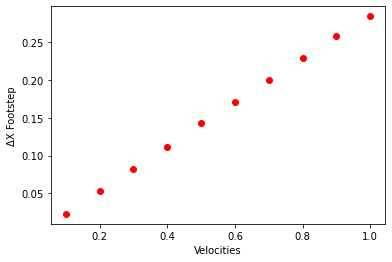

In [127]:
plt.plot([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
         [np.mean(Y_relative_footsteps_fwd[np.where(np.isclose(X_relative_footsteps_fwd[:, 0], velocity))[0], 0]) for velocity in np.arange(0.1, 1.1, 0.1)], 
         'ro')
plt.xlabel('Velocities')
plt.ylabel('\u0394X Footstep')
plt.show()

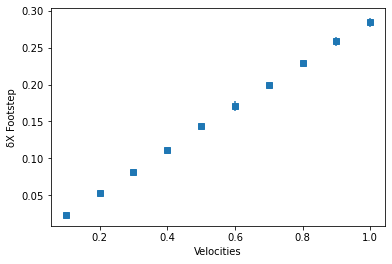

In [128]:
x = np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
y = np.array([np.mean(Y_relative_footsteps_fwd[np.where(np.isclose(X_relative_footsteps_fwd[:, 0], velocity))[0], 0]) for velocity in np.arange(0.1, 1.1, 0.1)])
e = np.array([np.std(Y_relative_footsteps_fwd[np.where(np.isclose(X_relative_footsteps_fwd[:, 0], velocity))[0], 0]) for velocity in np.arange(0.1, 1.1, 0.1)])
plt.errorbar(x, y, e, linestyle='None', marker='s')
plt.xlabel('Velocities')
plt.ylabel('\u03B4X Footstep')
plt.show()

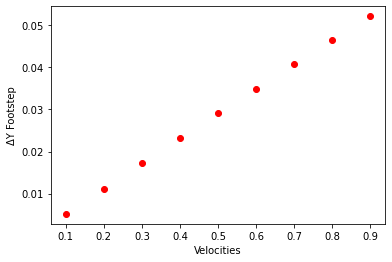

In [125]:
plt.plot(np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]) * 1,
         [np.mean(Y_relative_footsteps_count[np.where(np.isclose(X_relative_footsteps_count[:, 2], velocity))[0], 1]) for velocity in np.arange(0.1, 1.0, 0.1)], 
         'ro')
plt.xlabel('Velocities')
plt.ylabel('\u0394Y Footstep')
plt.show()

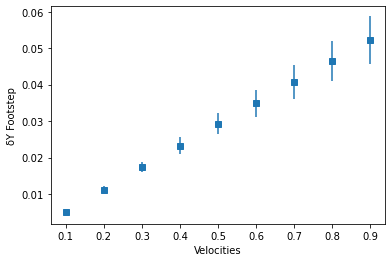

In [126]:
x = np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]) * 1
y = np.array([np.mean(Y_relative_footsteps_count[np.where(np.isclose(X_relative_footsteps_count[:, 2], velocity))[0], 1]) for velocity in np.arange(0.1, 1.0, 0.1)])
e = np.array([np.std(Y_relative_footsteps_count[np.where(np.isclose(X_relative_footsteps_count[:, 2], velocity))[0], 1]) for velocity in np.arange(0.1, 1.0, 0.1)])
plt.errorbar(x, y, e, linestyle='None', marker='s')
plt.xlabel('Velocities')
plt.ylabel('\u03B4Y Footstep')
plt.show()